Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

First, let's add L2 regularization for logistic regression.

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta = tf.placeholder(tf.float32)    
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Here beta is a hyperparameter that needs to be tuned. I will try several beta values, and pick the optimal one which gives the highest accuracy on validation dataset.

In [6]:
num_steps = 3001
beta_lst = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
valid_accuracy = []

for b in beta_lst:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : b}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))

Then I plot the accuracy on validation dataset corresponding to different beta values.

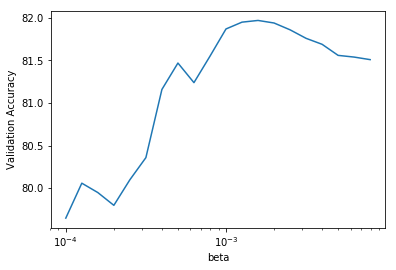

In [7]:
import matplotlib.pyplot as plt

plt.semilogx(beta_lst, valid_accuracy)
plt.xlabel('beta')
plt.ylabel('Validation Accuracy')
plt.show()

In [8]:
beta_lst[np.argmax(valid_accuracy)]

0.0015848931924611173

beta = 0.0016 gives the highest accuracy on validation dataset. I will use it to train logistic regression again, and test it on test dataset.

In [9]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.0016}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 23.873350
Minibatch accuracy: 10.9%
Validation accuracy: 12.5%
Minibatch loss at step 500: 2.671617
Minibatch accuracy: 82.0%
Validation accuracy: 76.8%
Minibatch loss at step 1000: 1.520974
Minibatch accuracy: 76.6%
Validation accuracy: 79.5%
Minibatch loss at step 1500: 0.814124
Minibatch accuracy: 82.0%
Validation accuracy: 80.8%
Minibatch loss at step 2000: 0.657473
Minibatch accuracy: 89.1%
Validation accuracy: 81.4%
Minibatch loss at step 2500: 0.750960
Minibatch accuracy: 80.5%
Validation accuracy: 81.7%
Minibatch loss at step 3000: 0.717209
Minibatch accuracy: 83.6%
Validation accuracy: 81.9%
Test accuracy: 89.1%


The L2 regularization improves test accuracy of logistic regression from 86.4% in Assignment 2 to 89.1%. Now let's add L2 regularization for 1-hidden layer neural network model.

In [10]:
# Train this 1-hidden layer neural network with SGD
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset) 
  beta = tf.placeholder(tf.float32)    
  
  # Variables.
  hidden_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  hidden_biases = tf.Variable(tf.zeros([num_hidden_nodes]))
  output_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  output_biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden_nodes = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
  logits = tf.matmul(hidden_nodes, output_weights) + output_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
    beta * (tf.nn.l2_loss(hidden_weights) + tf.nn.l2_loss(output_weights))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_hidden_nodes = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_nodes, output_weights) + output_biases)
  test_hidden_nodes = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_nodes, output_weights) + output_biases)

Then tune beta as I did for logistic regression.

In [11]:
valid_accuracy = []

for b in beta_lst:
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : b}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy.append(accuracy(valid_prediction.eval(), valid_labels))

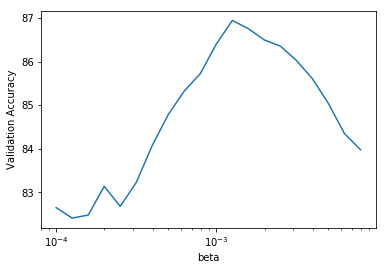

In [12]:
plt.semilogx(beta_lst, valid_accuracy)
plt.xlabel('beta')
plt.ylabel('Validation Accuracy')
plt.show()

In [13]:
beta_lst[np.argmax(valid_accuracy)]

0.0012589254117941701

Again, beta = 0.0013 gives the highest accuracy on validation dataset. I will use it to train 1-hidden layer neural network again, and test it on test dataset.

In [14]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 0.0013}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 737.835083
Minibatch accuracy: 14.1%
Validation accuracy: 20.1%
Minibatch loss at step 500: 221.370239
Minibatch accuracy: 79.7%
Validation accuracy: 76.7%
Minibatch loss at step 1000: 110.800758
Minibatch accuracy: 78.1%
Validation accuracy: 82.0%
Minibatch loss at step 1500: 56.822105
Minibatch accuracy: 89.1%
Validation accuracy: 83.6%
Minibatch loss at step 2000: 29.571346
Minibatch accuracy: 91.4%
Validation accuracy: 85.5%
Minibatch loss at step 2500: 15.660949
Minibatch accuracy: 88.3%
Validation accuracy: 86.5%
Minibatch loss at step 3000: 8.503495
Minibatch accuracy: 85.9%
Validation accuracy: 86.7%
Test accuracy: 93.2%


The L2 regularization improves test accuracy of 1-hidden layer neural network from 89.5% in Assignment 2 to 93.2%.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

I will do this experiment on neural network without regularization, only using 2 batches to train the model.

In [15]:
# Train this 1-hidden layer neural network with SGD
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  hidden_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  hidden_biases = tf.Variable(tf.zeros([num_hidden_nodes]))
  output_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  output_biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden_nodes = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)
  logits = tf.matmul(hidden_nodes, output_weights) + output_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_hidden_nodes = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_nodes, output_weights) + output_biases)
  test_hidden_nodes = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_nodes, output_weights) + output_biases)

In [16]:
num_batches = 2
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    # Only use two batches here to train the model.
    offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 405.398438
Minibatch accuracy: 7.8%
Validation accuracy: 31.0%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.7%
Test accuracy: 80.0%


The training loss reaches 0 at an early stage, however, as the training data is too small, overfitting occurs and the model fails to generalize to new data, as evidenced by low test accuracy.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [17]:
# Train this 1-hidden layer neural network with SGD
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  hidden_weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  hidden_biases = tf.Variable(tf.zeros([num_hidden_nodes]))
  output_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  output_biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # Introduce dropout on the hidden layer.
  hidden_nodes = tf.nn.dropout((tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases)), 0.5)
  logits = tf.matmul(hidden_nodes, output_weights) + output_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_hidden_nodes = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_nodes, output_weights) + output_biases)
  test_hidden_nodes = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_nodes, output_weights) + output_biases)

In [18]:
num_batches = 2
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 449.548218
Minibatch accuracy: 14.1%
Validation accuracy: 18.8%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.3%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.1%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.8%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.6%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 76.2%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 75.9%
Test accuracy: 82.9%


The neural network becomes more robust and performs better at generalizing to new data, as evidenced by higher test accuracy.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Here I will use two ways at the same time to achieve a better performance:

- Add two more hidden layers in addition to the first hidden layer
- Use learning rate decay

In [27]:
# Train this 1-hidden layer neural network with SGD
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  
  # Variables.
  hidden_weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes1], stddev = 0.02))
  hidden_biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  hidden_weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev = 0.02))
  hidden_biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  hidden_weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev = 0.02))
  hidden_biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  output_weights = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev = 0.02))
  output_biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden_nodes1 = tf.nn.relu(tf.matmul(tf_train_dataset, hidden_weights1) + hidden_biases1)
  hidden_nodes2 = tf.nn.relu(tf.matmul(hidden_nodes1, hidden_weights2) + hidden_biases2)
  hidden_nodes3 = tf.nn.relu(tf.matmul(hidden_nodes2, hidden_weights3) + hidden_biases3)
  logits = tf.matmul(hidden_nodes3, output_weights) + output_biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 3000, 0.8, staircase = True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step = global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_hidden_nodes1 = tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights1) + hidden_biases1)
  valid_hidden_nodes2 = tf.nn.relu(tf.matmul(valid_hidden_nodes1, hidden_weights2) + hidden_biases2)
  valid_hidden_nodes3 = tf.nn.relu(tf.matmul(valid_hidden_nodes2, hidden_weights3) + hidden_biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_nodes3, output_weights) + output_biases)
  test_hidden_nodes1 = tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights1) + hidden_biases1)
  test_hidden_nodes2 = tf.nn.relu(tf.matmul(test_hidden_nodes1, hidden_weights2) + hidden_biases2)
  test_hidden_nodes3 = tf.nn.relu(tf.matmul(test_hidden_nodes2, hidden_weights3) + hidden_biases3)
  test_prediction = tf.nn.softmax(tf.matmul(test_hidden_nodes3, output_weights) + output_biases)

In [28]:
num_steps = 15001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.302873
Minibatch accuracy: 8.6%
Validation accuracy: 9.5%
Minibatch loss at step 1000: 0.469952
Minibatch accuracy: 84.4%
Validation accuracy: 86.3%
Minibatch loss at step 2000: 0.272188
Minibatch accuracy: 93.0%
Validation accuracy: 88.1%
Minibatch loss at step 3000: 0.355145
Minibatch accuracy: 87.5%
Validation accuracy: 89.0%
Minibatch loss at step 4000: 0.253991
Minibatch accuracy: 92.2%
Validation accuracy: 89.4%
Minibatch loss at step 5000: 0.304947
Minibatch accuracy: 91.4%
Validation accuracy: 89.5%
Minibatch loss at step 6000: 0.371075
Minibatch accuracy: 89.8%
Validation accuracy: 89.9%
Minibatch loss at step 7000: 0.357258
Minibatch accuracy: 87.5%
Validation accuracy: 90.5%
Minibatch loss at step 8000: 0.357800
Minibatch accuracy: 85.9%
Validation accuracy: 90.2%
Minibatch loss at step 9000: 0.223471
Minibatch accuracy: 94.5%
Validation accuracy: 90.0%
Minibatch loss at step 10000: 0.174483
Minibatch accuracy: 95.3%
Validation accurac

Reference
---------

[1] https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/udacity

[2] https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow

[3] https://github.com/rndbrtrnd/udacity-deep-learning

The test accuracy reaches 96.0%!